In [18]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

from keras_tuner import HyperParameters
from keras_tuner.tuners import RandomSearch

In [19]:
df = pd.read_csv('./data/indonesian_texts_labeled_relaxed.csv')

df.head()

,cid,submittedVideoUrl,text,label,is_english,normalized_text,text_without_stopwords,stemmed_text,final_text,combined_text
0,7.424290e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah,1.0,False,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah,sayangnya orang-orang terdekat justru membuat mental sakit lelah,sayang orang dekat justru buat mental sakit lelah,sayang orang dekat justru buat mental sakit lelah,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah
1,7.424297e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"justru malah org trdekat yg menghancurkan mental ku, aku tdk prcya siapapun, caraku mengatasi ini semua dgn meditasi agar lbih tenang",1.0,False,"justru malah orang trdekat yang menghancurkan mental ku, saya tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang","justru orang trdekat menghancurkan mental ku, prcya siapapun, caraku mengatasi meditasi lbih tenang",justru orang trdekat hancur mental ku prcya siapa cara atas meditasi lbih tenang,justru orang trdekat hancur mental ku prcya siapa cara atas meditasi lbih tenang,"justru malah org trdekat yg menghancurkan mental ku, aku tdk prcya siapapun, caraku mengatasi ini semua dgn meditasi agar lbih tenang justru malah orang trdekat yang menghancurkan mental ku, saya tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang"
2,7.467563e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,halo ka indah sundari,0.0,False,halo ka indah sundari,ka indah sundari,ka indah sundari,ka indah sundari,halo ka indah sundari halo ka indah sundari
3,7.424316e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,justru orang terdekat malah jadi penyebabnya,0.0,False,justru orang terdekat malah jadi penyebabnya,justru orang terdekat penyebabnya,justru orang dekat sebab,justru orang dekat sebab,justru orang terdekat malah jadi penyebabnya justru orang terdekat malah jadi penyebabnya
4,7.455553e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,ka tolong aku,1.0,False,ka tolong saya,ka,ka,ka,ka tolong aku ka tolong saya


In [20]:
# Load normalization dictionary from kbba.txt
normalization_dict = pd.read_csv('kbba.txt', delimiter='\t', names=['slang', 'formal'], header=None, encoding='utf-8')

slang_dict = dict(zip(normalization_dict['slang'], normalization_dict['formal']))
slang_dict

{'7an': 'tujuan',
 '@': 'di',
 'g': 'gak',
 'ka': 'kakak',
 'ababil': 'abg labil',
 'abis': 'habis',
 'acc': 'terima',
 'accor': 'accord',
 'ad': 'ada',
 'adlah': 'adalah',
 'adlh': 'adalah',
 'adoh': 'aduh',
 'afaik': 'as far as i know',
 'aha': 'tertawa',
 'ahaha': 'haha',
 'aing': 'saya',
 'aj': 'saja',
 'aja': 'saja',
 'ajep-ajep': 'dunia gemerlap',
 'ajj': 'saja',
 'ak': 'saya',
 'aka': 'dikenal juga sebagai',
 'akika': 'aku',
 'akko': 'aku',
 'akkoh': 'aku',
 'akku': 'aku',
 'akuwh': 'aku',
 'akyu': 'aku',
 'alay': 'norak',
 'alesan': 'alasan',
 'aljasa': 'asal jadi saja',
 'alow': 'halo',
 'ama': 'sama',
 'ambilin': 'ambilkan',
 'ambl': 'ambil',
 'ancur': 'hancur',
 'and': 'dan',
 'anjir': 'anjing',
 'anjrit': 'anjing',
 'ank': 'anak',
 'anter': 'antar',
 'ap': 'apa',
 'ap2': 'apa-apa',
 'apaan': 'apa',
 'apasih': 'apa sih',
 'ape': 'apa',
 'apes': 'sial',
 'apk': 'aplikasi',
 'aplot': 'unggah',
 'aplikasih': 'aplikasi',
 'app': 'aplikasi',
 'applikasi': 'aplikasi',
 'aps': 'apa

In [21]:
# Set up Indonesian stopwords and stemmer
stop_factory = StopWordRemoverFactory()
stopwords_sastrawi = set(stop_factory.get_stop_words())
stemmer = StemmerFactory().create_stemmer()
custom_stopwords = {
    # Pronouns & common personal references
    'aku', 'kamu', 'dia', 'kami', 'kita', 'mereka', 'saya', 'anda', 'gw', 'gue', 'lu', 'loe', 'lo', 'gua', 'kak', 'kakak',
    
    # Formal stopwords
    'yang', 'dan', 'di', 'ke', 'dari', 'pada', 'dengan', 'untuk', 'dalam', 'adalah', 'itu', 'ini',
    'juga', 'sebagai', 'oleh', 'karena', 'agar', 'atau', 'tetapi', 'namun', 'sehingga', 'supaya',
    'bagi', 'tanpa', 'bahwa', 'kalau', 'jika', 'saat', 'sebelum', 'sesudah', 'setelah', 'sementara',
    'sambil', 'sedangkan', 'seperti', 'hingga', 'meskipun', 'nya',

    # Common verbs & auxiliaries
    'adalah', 'ialah', 'merupakan', 'bukan', 'sudah', 'belum', 'akan', 'lagi', 'pernah',
    'harus', 'mau', 'dapat', 'bisa',

    # Informal abbreviations/slang
    'gak', 'ga', 'nggak', 'ngga', 'tdk', 'ngerti', 'sih', 'aja', 'kok', 'dong', 'nih', 'deh',
    'ya', 'yah', 'yee', 'loh', 'lah', 'cie', 'eh', 'btw', 'kalo', 'kalau', 'tp', 'yg', 'dr', 'pd', 'trs', 'klo'

    # Internet filler
    'wkwk', 'wkwkwk', 'haha', 'hehe', 'huhu', 'ckck', 'lol', 'lmao', 'anjay', 'banget', 'mantul',

    # Temporal
    'kemarin', 'besok', 'nanti', 'sekarang', 'tadi', 'barusan',

    # Common question words
    'apa', 'kenapa', 'mengapa', 'dimana', 'kapan', 'siapa', 'bagaimana'
}

extended_stopwords = stopwords_sastrawi.union(custom_stopwords)

def normalize_text(text):
    words = text.split()

    normalized_words = [slang_dict[word] if word in slang_dict else word for word in words]
    return " ".join(normalized_words)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in extended_stopwords])
    text = stemmer.stem(text)  # stemming in Bahasa Indonesia
    return text


In [22]:
df['text'] = df['text'].apply(normalize_text)

df.head()

,cid,submittedVideoUrl,text,label,is_english,normalized_text,text_without_stopwords,stemmed_text,final_text,combined_text
0,7.424290e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah,1.0,False,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah,sayangnya orang-orang terdekat justru membuat mental sakit lelah,sayang orang dekat justru buat mental sakit lelah,sayang orang dekat justru buat mental sakit lelah,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah
1,7.424297e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"justru bahkan orang trdekat yang menghancurkan mental ku, aku tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang",1.0,False,"justru malah orang trdekat yang menghancurkan mental ku, saya tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang","justru orang trdekat menghancurkan mental ku, prcya siapapun, caraku mengatasi meditasi lbih tenang",justru orang trdekat hancur mental ku prcya siapa cara atas meditasi lbih tenang,justru orang trdekat hancur mental ku prcya siapa cara atas meditasi lbih tenang,"justru malah org trdekat yg menghancurkan mental ku, aku tdk prcya siapapun, caraku mengatasi ini semua dgn meditasi agar lbih tenang justru malah orang trdekat yang menghancurkan mental ku, saya tidak prcya siapapun, caraku mengatasi ini semua dengan meditasi agar lbih tenang"
2,7.467563e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,halo kakak indah sundari,0.0,False,halo ka indah sundari,ka indah sundari,ka indah sundari,ka indah sundari,halo ka indah sundari halo ka indah sundari
3,7.424316e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,justru orang terdekat bahkan jadi penyebabnya,0.0,False,justru orang terdekat malah jadi penyebabnya,justru orang terdekat penyebabnya,justru orang dekat sebab,justru orang dekat sebab,justru orang terdekat malah jadi penyebabnya justru orang terdekat malah jadi penyebabnya
4,7.455553e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,kakak tolong aku,1.0,False,ka tolong saya,ka,ka,ka,ka tolong aku ka tolong saya


In [23]:
text_column = 'text'
label_column = 'label'

df = df[[text_column, label_column]].dropna()
df[text_column] = df[text_column].astype(str).apply(preprocess_text)

if df[label_column].dtype != int:
    le = LabelEncoder()
    df[label_column] = le.fit_transform(df[label_column])

df.head()

,text,label
0,sayang orangorang dekat justru buat mental sakit lelah,1
1,justru bahkan orang trdekat hancur mental ku prcya siapa cara atas semua meditasi lbih tenang,1
2,halo indah sundari,0
3,justru orang dekat bahkan jadi sebab,0
4,,1


In [24]:
vocab_size = 10000
max_len = 100
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df[text_column])
sequences = tokenizer.texts_to_sequences(df[text_column])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

word_index = tokenizer.word_index

In [25]:
embedding_index = {}
embedding_dim = 300  # FastText Indo = 300 dimensions

with open('cc.id.300.vec', encoding='utf-8') as f:
    next(f)  # Skip the header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df[label_column], test_size=0.3, random_state=42)

In [27]:
def build_model(hp):
    model = Sequential()

    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=hp.Choice('embedding_trainable', [True, False])
    ))

    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
        return_sequences=True
    )))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.1)))

    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)
    )))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.6, step=0.1)))

    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg', 1e-4, 1e-2, sampling='log'))
    ))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.6, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [28]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='sentiment_tuning30'
)

c:\Users\Mufid Musyaffa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
tuner.search(X_train, y_train,
             epochs=5,
             batch_size=32,
             validation_split=0.3,
             verbose=1)

Trial 10 Complete [00h 04m 09s]
val_accuracy: 0.8791503012180328

Best val_accuracy So Far: 0.9412709772586823
Total elapsed time: 01h 07m 07s


In [34]:
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hyperparams)
best_hyperparams.values

c:\Users\Mufid Musyaffa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


{'embedding_trainable': 1,
 'lstm_units_1': 32,
 'dropout_1': 0.30000000000000004,
 'lstm_units_2': 16,
 'dropout_2': 0.5,
 'dense_units': 96,
 'l2_reg': 0.0009650445209861275,
 'dropout_3': 0.5,
 'learning_rate': 0.007913979537147965}

In [35]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.3,
    validation_data=None,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.8208 - loss: 0.4272 - val_accuracy: 0.9357 - val_loss: 0.2624
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.9670 - loss: 0.1375 - val_accuracy: 0.9347 - val_loss: 0.2436
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - accuracy: 0.9894 - loss: 0.0537 - val_accuracy: 0.9343 - val_loss: 0.2829
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.9890 - loss: 0.0431 - val_accuracy: 0.9304 - val_loss: 0.3822
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - accuracy: 0.9940 - loss: 0.0288 - val_accuracy: 0.9290 - val_loss: 0.4892


In [36]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 64)        │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,296,645 (35.46 MB)

 Trainable params: 3,098,881 (11.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,197,764 (23.64 MB)

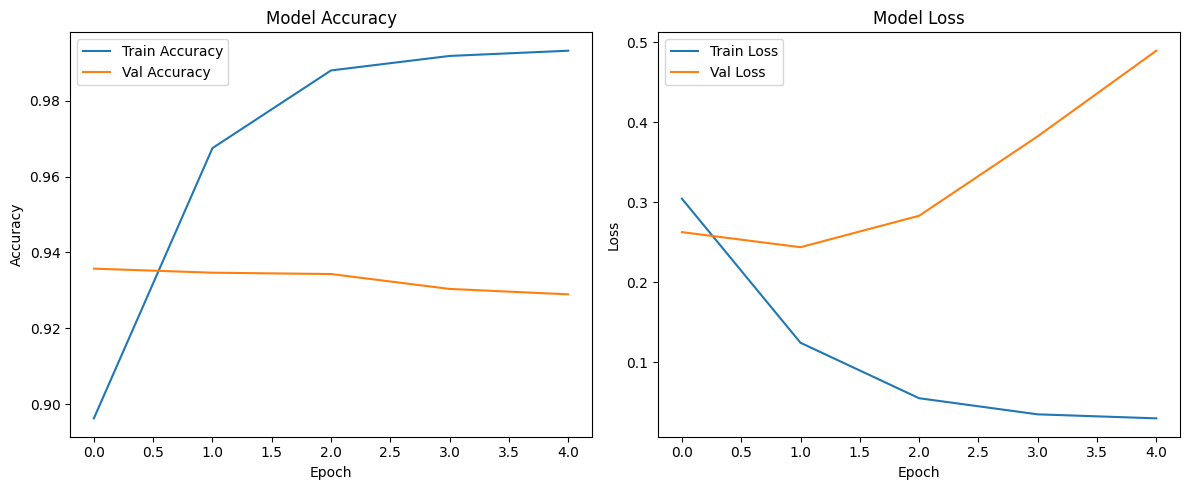

In [37]:
# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step


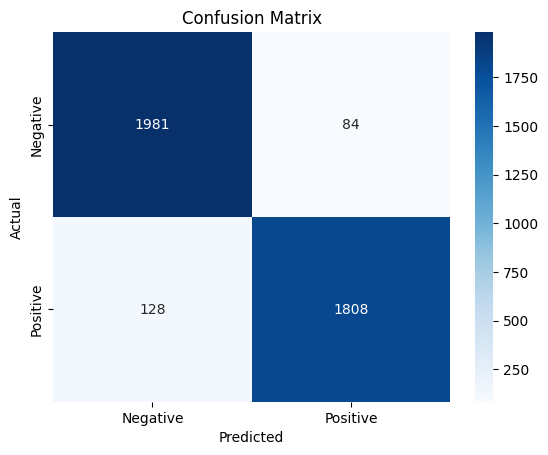


Classification Report:

              precision    recall  f1-score   support

    Negative       0.94      0.96      0.95      2065
    Positive       0.96      0.93      0.94      1936

    accuracy                           0.95      4001
   macro avg       0.95      0.95      0.95      4001
weighted avg       0.95      0.95      0.95      4001

126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9487 - loss: 0.2014

Test Results:

Loss: 0.1982576996088028
Accuracy: 0.947013258934021


In [38]:
# Predictions
y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

test_results = best_model.evaluate(X_test, y_test)
print("\nTest Results:\n")
print(f"Loss: {test_results[0]}")
print(f"Accuracy: {test_results[1]}")